In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Question 1

## Question 1: Top 10 Bundesliga teams over entire period

**Metric: Points Per Game (PPG)**
- 3 points for win
- 1 point for draw
- 0 points for loss

Same point system as used in real life, ensures fairness, eliminates goal outliers and also gives points for draws. 

In [2]:
# Load data
df = pd.read_csv('data/bundesliga.csv')

# Convert Date to datetime 
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)

# Quick look
print(f"Dataset shape: {df.shape}")
print(f"\nDate range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (7650, 11)

Date range: 1993-08-07 00:00:00 to 2018-05-12 00:00:00

First few rows:


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Season
0,D1,1993-08-07,Bayern Munich,Freiburg,3,1,H,NaN,NaN,NaN,1993-94
1,D1,1993-08-07,Dortmund,Karlsruhe,2,1,H,NaN,NaN,NaN,1993-94
2,D1,1993-08-07,Duisburg,Leverkusen,2,2,D,NaN,NaN,NaN,1993-94
3,D1,1993-08-07,FC Koln,Kaiserslautern,0,2,A,NaN,NaN,NaN,1993-94
4,D1,1993-08-07,Hamburg,Nurnberg,5,2,H,NaN,NaN,NaN,1993-94


In [5]:
# Check for missing values
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7650 entries, 0 to 7649
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Div       7650 non-null   str           
 1   Date      7650 non-null   datetime64[us]
 2   HomeTeam  7650 non-null   str           
 3   AwayTeam  7650 non-null   str           
 4   FTHG      7650 non-null   int64         
 5   FTAG      7650 non-null   int64         
 6   FTR       7650 non-null   str           
 7   HTHG      7038 non-null   float64       
 8   HTAG      7038 non-null   float64       
 9   HTR       7038 non-null   str           
 10  Season    7650 non-null   str           
dtypes: datetime64[us](1), float64(2), int64(2), str(6)
memory usage: 657.6 KB


## Calculate Points for Each Team

In [6]:
def calculate_team_stats(df):
    stats = {}
    
    # Process matches
    for _, row in df.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        result = row['FTR']
        
        # Initialize teams if not seen before
        if home_team not in stats:
            stats[home_team] = {'games': 0, 'points': 0}
        if away_team not in stats:
            stats[away_team] = {'games': 0, 'points': 0}
        
        # Update home team stats
        stats[home_team]['games'] += 1
        
        if result == 'H': 
            stats[home_team]['points'] += 3
        elif result == 'D':     
            stats[home_team]['points'] += 1
        
        # Update away team stats
        stats[away_team]['games'] += 1
        
        if result == 'A': 
            stats[away_team]['points'] += 3
        elif result == 'D':     
            stats[away_team]['points'] += 1
    
    return stats

In [7]:
# Calculate stats
team_stats = calculate_team_stats(df)

# Convert to df
stats_df = pd.DataFrame.from_dict(team_stats, orient='index')
stats_df.index.name = 'Team'
stats_df.reset_index(inplace=True)

# Calculate derived metrics
stats_df['PPG'] = stats_df['points'] / stats_df['games']

print(f"Total teams in dataset: {len(stats_df)}")
stats_df.head(10)

Total teams in dataset: 43


,Team,games,points,PPG
0,Bayern Munich,850,1820,2.141176
1,Freiburg,612,719,1.174837
2,Dortmund,850,1472,1.731765
3,Karlsruhe,238,306,1.285714
4,Duisburg,272,292,1.073529
5,Leverkusen,850,1415,1.664706
6,FC Koln,578,644,1.114187
7,Kaiserslautern,476,664,1.394958
8,Hamburg,850,1148,1.350588
9,Nurnberg,442,490,1.108597


In [ ]:
# Filter teams with min 100 games and get top 10
min_games = 100

filtered_stats = stats_df[stats_df['games'] >= min_games]
top_10 = filtered_stats.sort_values('PPG', ascending=False).head(10)

print(f"=== TOP 10 BUNDESLIGA TEAMS (1993-2018) ===")
print(f"Filtered by minimum {min_games} games | Teams remaining: {len(filtered_stats)}\n")

top_10[['Team', 'games', 'PPG']]

=== TOP 10 BUNDESLIGA TEAMS (1993-2018) ===
Filtered by minimum 100 games | Teams remaining: 27



,Team,games,PPG
0,Bayern Munich,850,2.141176
2,Dortmund,850,1.731765
5,Leverkusen,850,1.664706
15,Schalke 04,850,1.568235
16,Werder Bremen,850,1.494118
17,Stuttgart,816,1.441176
7,Kaiserslautern,476,1.394958
27,Hertha,646,1.385449
26,Wolfsburg,714,1.379552
8,Hamburg,850,1.350588


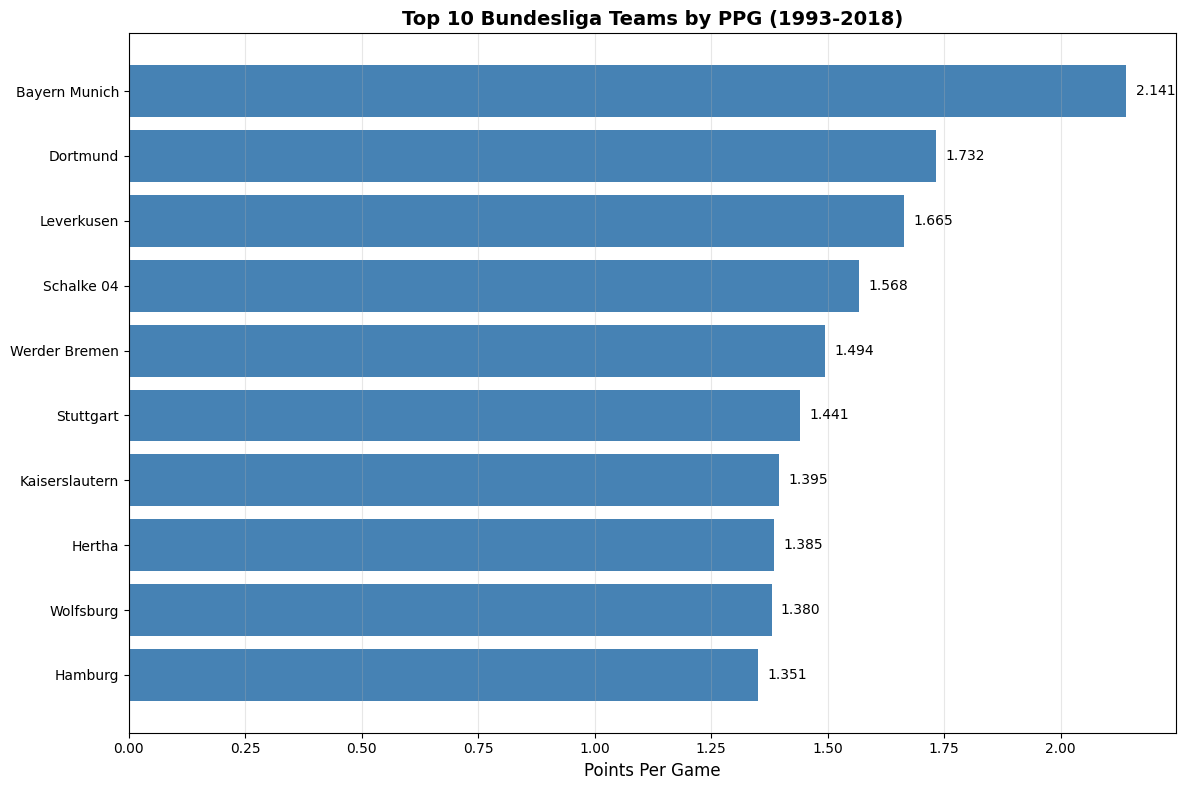

In [14]:
# Bar chart of top 10 teams
fig, ax = plt.subplots(figsize=(12, 8))

# PPG comparison
ax.barh(range(len(top_10)), top_10['PPG'].values, color='steelblue')
ax.set_yticks(range(len(top_10)))
ax.set_yticklabels(top_10['Team'].values)
ax.set_xlabel('Points Per Game', fontsize=12)
ax.set_title('Top 10 Bundesliga Teams by PPG (1993-2018)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, v in enumerate(top_10['PPG'].values):
    ax.text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()